# Data Vizualization and Dimensionality Reduction

Last time, we implemented PCA and Kernel PCA, which are two classical techniques to reduce the dimension of the data. Reducing the dimension of the data is not only useful as data processing, but also as a data vizualization tool. In this class, we will implement three classical algorithms in data vizualization and/or dimension reduction, based on geometrical methods:
* Multidimension Scaling
* Metric Multidimensional Scaling
* Isomap

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.datasets import make_swiss_roll

## Multidimensional Scaling (MDS)

Let us consider a dataset with $n$ data. The features can be numerical or categorial, but we assume we can compute some dissimilarity value $D_{ij}$ between any pair of data $i$ and $j$. The goal is to recover some points $z_1, \ldots, z_n \in \mathbb{R}^d$, with $d$ not too large (take $d=2$ for vizualization for example) such that the points $\{z_i\}$ represent "well" the dataset.

What does it mean that it respresents "well" the dataset ? Imagine that the initial dataset is made of $n$ points $x_1, \ldots, x_n \in \mathbb{R}^p$ (i.e. there are $p$ numerical features), and that the dissimilarities have been computed by $D_{ij} = \|x_i - x_j\|^2$. Defining $G \in \mathbb{R}^{n \times n}$ the Gram matrix of the data, i.e. $G_{ij} = x_i^T x_j$, some basic computations show that:
$$
    G = -\frac{1}{2}P D P
$$
where $P = I - \frac{1}{n}1_n$ with $1_n$ the $n \times n$ matrix with all coefficients equal to $1$.

By computing $Z \in \mathbb{R}^{n \times p}$ such that $G = Z Z^T$, and denoting by $z_i$ the $i$-th row of $Z$, it is clear that $G_{ij} = z_i^T z_j$. Note that since $G$ is of rank at most $p$, it is always possible to compute such a $Z$. We can compute $Z$ by performing the eigendecomposition of $G$, and drop all the zeros eigenvalues (if any).

If we now want to reduce the dimension from $p$ to $d$, we can always compute the eigendecomposition of $G$, and keep only the $d$ largest eigenvalues of $G$. Note that if the dissimilarities were note computed from high-dimensional points, the matrix $G$ may have negative eigenvalues, in which case we can always set them to zero.

### Dataset

We consider some synthetic data in $p=3$ dimension. This data is not linear, but clearly follows some one-dimensional pattern (the roll).

In [2]:
n = 400 # Number of points to consider (size of the dataset)
X, y = make_swiss_roll(n_samples=n, noise=0.5) # X contains the point, y their color

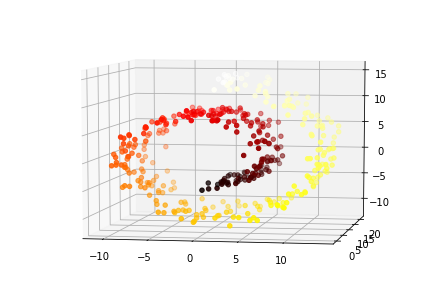

In [3]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
ax.scatter(X[:,0], X[:,1], X[:,2], 'o', cmap='hot', c=(y/np.max(y)))
plt.show()

### Algorithm

First, we define a `dissimilarity` function that will compute the dissimilarity matrix $D$.

In [4]:
def dissimilarity(data):
    '''
        Return the dissimilarity between the points in matrix `data` (n_samples, n_features).
        Here, the dissimilarity is the squared Euclidean norm. It could be something else.
    '''
    data_sq = np.sum(data**2, 1)
    D = data_sq + data_sq[:, None] - 2 * data.dot(data.T)
    return D

Now, we need to "center" the data, i.e. compute the Gram matrix $G$.

In [5]:
def gram(D):
    '''
        Return the Gram matrix associated with the dissimilarity matrix `D`.
    '''
    n = D.shape[0]
    P = np.identity(n) - np.ones((n,n))/n
    G = -1/2 * P.dot(D).dot(P)
    return G

We can now compute the eigendecomposition of $G$, and keep the $d$ largest eigenvalues.

In [6]:
def MDS(data, d=2):
    '''
        Compute the MDS of the dataset in matrix `data`(n_samples, n_features), with target dimension `d`.
    '''
    
    D = dissimilarity(data)
    G = gram(D)
    eigenvalues, eigenvectors = np.linalg.eigh(G)
    
    return eigenvectors[:,-d:].dot(np.diag(np.sqrt(eigenvalues[-d:])))

### Results

In two dimensions:

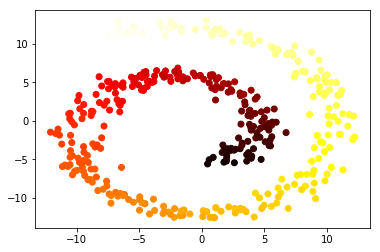

In [7]:
X_reduced = MDS(X, d=2)
plt.scatter(X_reduced[:,0], X_reduced[:,1], cmap='hot', c=(y/np.max(y)))
plt.show()

In one dimension:

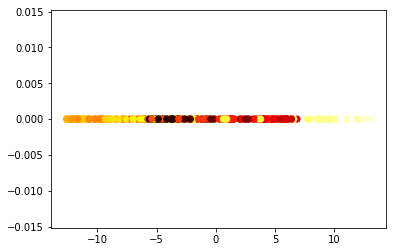

In [8]:
X_reduced = MDS(X, d=1)
plt.scatter(X_reduced, np.zeros(n), cmap='hot', c=(y/np.max(y)))
plt.show()

## Metric Multidimensional Scaling (mMDS)

In Metric MDS, we now seek to find some points $z_1, \ldots, z_n \in \mathbb{R}^d$ such that
$$
    \forall i,j,\, D_{ij} \approx \|z_i - z_j\|.
$$

More formally, we want to find the points $z_1, \ldots, z_n \in \mathbb{R}^d$ that will minimize the loss (called here `stress`):
$$
    \mathcal{S}(z_1, \ldots, z_n) := \sum_{i,j} \left( D_{ij} - \|z_i - z_j\| \right)^2.
$$

This is a non-convex problem, and should be difficult to optimize. But we can actually bound above the stress by a convex function $\mathcal{L}$. We will minimize this convex loss $\mathcal{L}$ instead of the stress $\mathcal{S}$. This minimization can be done very efficiently using the SMACOF algorithm.

### Algorithm

In [9]:
def dissimilarity_sqrt(data):
    '''
        Return the Euclidean distance between the points in the dataset `data`.
    '''
    D = dissimilarity(data)
    D = np.maximum(D, 0)
    return np.sqrt(D)

In [10]:
def B(Z, D):
    '''
        Return the matrix B in SMACOF iteration.
    '''
    A = -np.divide(D, dissimilarity_sqrt(Z)+1e-20) # Add 1e-20 for stability issues
    A = A - np.diag(np.sum(A,0))
    return A

In [11]:
def mMDS(data, d=2, N_iter=100, D_precomputed=None):
    '''
        Compute the mMDS of the dataset `data`, with target dimension `d` and `N_iter` iterations in SMACOF.
    '''
    n = data.shape[0]
    
    # Initialize at random
    Z = np.random.normal(size=d*n).reshape([n,d])
    
    if D_precomputed is None:
        D = dissimilarity_sqrt(X)
    else:
        D = D_precomputed
    # Run the algorithm
    stress = []
    for i in range(N_iter):
        Z = B(Z,D).dot(Z)/n
        stress.append(np.sum(np.sum((D-dissimilarity_sqrt(Z))**2)))
    
    return Z, np.array(stress)/(n*n)

### Results

In dimension 2:

In [12]:
Z, stress = mMDS(X, d=2, N_iter=200)
print('Stress value =', stress[-1])

Stress value = 11.084988369869729


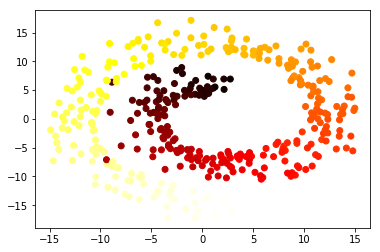

In [13]:
plt.scatter(Z[:,0], Z[:,1], cmap='hot', c=(y/np.max(y)))
plt.show()

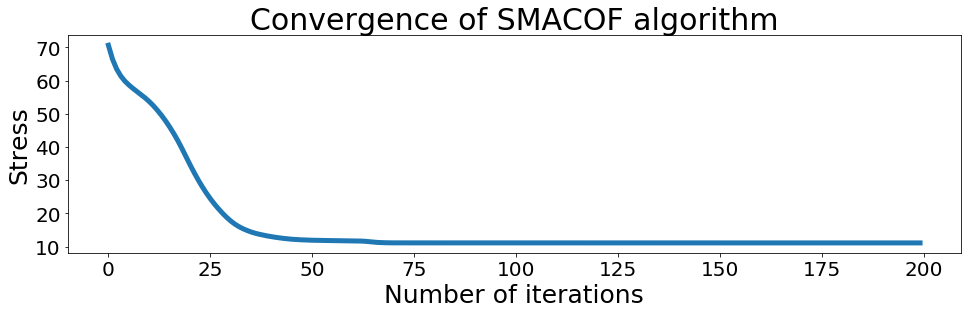

In [14]:
plt.figure(figsize=(16,4))
plt.title('Convergence of SMACOF algorithm', fontsize=30)
plt.plot(stress, lw=5)
plt.ylabel('Stress', fontsize=25)
plt.xlabel('Number of iterations', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In dimension 1:

In [15]:
Z, stress = mMDS(X, d=1, N_iter=200)
print('Stress value =', stress[-1])

Stress value = 60.40203365507275


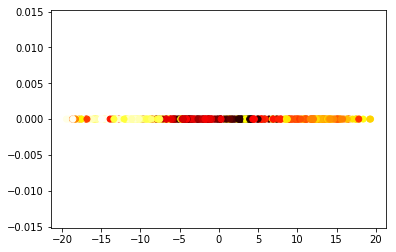

In [16]:
plt.scatter(Z, np.zeros(n), cmap='hot', c=(y/np.max(y)))
plt.show()

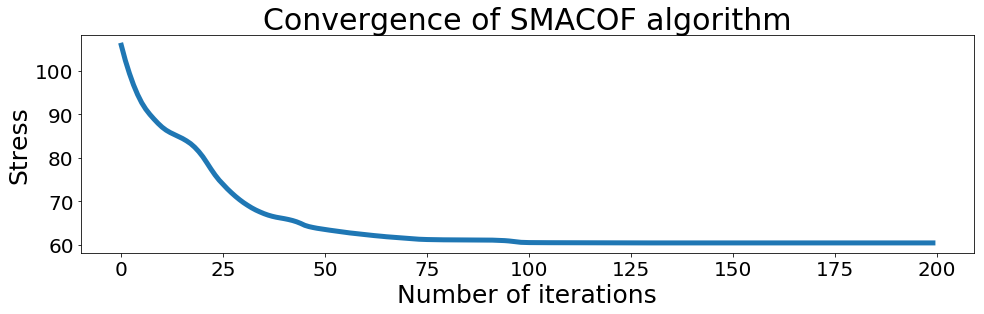

In [17]:
plt.figure(figsize=(16,4))
plt.title('Convergence of SMACOF algorithm', fontsize=30)
plt.plot(stress, lw=5)
plt.ylabel('Stress', fontsize=25)
plt.xlabel('Number of iterations', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## Isomap

In MDS and metric MDS, the main problem is that the dissimilarities are computed as (squared) Euclidean distances. But clearly on the Swiss Roll, two points can be close in terms of Euclidean distance, but far away in terms of the geodesic distance on the Roll.

Isomap is a tentative to solve this problem by:
1. Computing dissimilarities that are not Euclidean, but "geodesic";
2. Apply metric MDS to this dissimilarity matrix.

The "geodesic" distance between the points in the dataset has to be thought this way. First, compute a graph of nearest neighbors, so that points that are close to each other are linked by an edge. Then, the "geodesic" distance between two points in the dataset is simply the (weighted) length of the shortest path in the graph.

### Compute the Nearest Neighbors Graph

For each point $i$ in the dataset, we will compute its $k$ nearest neighbors and draw an edge between $i$ and all its nearest neighbors.

In [18]:
# k-Nearest-Neighbors
k = 10

In [19]:
from sklearn.neighbors import kneighbors_graph
graph = kneighbors_graph(X, k, mode='distance')

### Compute the geodesic distance using Floyd–Warshall algorithm

Compute the geodesic graph distance using Floyd-Warshall algorithm.

In [20]:
from sklearn.utils.graph_shortest_path import graph_shortest_path
geodesic_distance = graph_shortest_path(graph)

### Results

In [21]:
Z, stress = mMDS(X, d=2, N_iter=200, D_precomputed=geodesic_distance)
print('Stress value =', stress[-1])

Stress value = 80.75225816207899


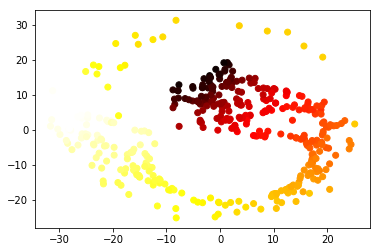

In [22]:
plt.scatter(Z[:,0], Z[:,1], cmap='hot', c=(y/np.max(y)))
plt.show()

In [23]:
Z, stress = mMDS(X, d=1, N_iter=200, D_precomputed=geodesic_distance)
print('Stress value =', stress[-1])

Stress value = 395.43045532750847


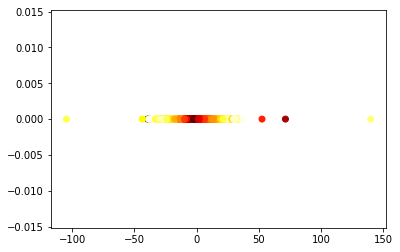

In [24]:
plt.scatter(Z, np.zeros(n), cmap='hot', c=(y/np.max(y)))
plt.show()